# 🎬 Adaptive Video Search Engine

**자연어 쿼리 기반 지능형 비디오 검색 시스템**

이 노트북은 CLIP, BLIP-2, Gemini API를 활용한 비디오 검색 엔진을 구현합니다.

## 📋 주요 기능
1. **지능형 쿼리 분석**: Gemini API로 한국어 쿼리를 동작 시퀀스로 분할
2. **적응형 매칭 엔진**: CLIP 기반 유사도 계산 + 변곡점 탐지
3. **2단계 검색**: CLIP → BLIP-2 보정으로 정확도 향상
4. **실시간 시각화**: 검색 진행 상황을 그래프로 표시

## 📦 시작하기 전에
- GPU 사용 권장 (BLIP-2 사용 시)
- `.env` 파일에 `GEMINI_API_KEY` 설정 필요
- 비디오 파일 준비 (`sample_video.mp4`)

In [12]:
%%bash
cd /content
rm -rf YAI_17_Winter_Project
git clone https://github.com/Dindb-dong/YAI_17_Winter_Project.git

Cloning into 'YAI_17_Winter_Project'...


In [16]:
%%bash
cd /content/YAI_17_Winter_Project
git switch yys

Branch 'yys' set up to track remote branch 'yys' from 'origin'.


Switched to a new branch 'yys'


## 1. 패키지 설치

먼저 필요한 패키지들을 설치합니다.

In [1]:
%pip install transformers opencv-python pillow numpy google-genai python-dotenv matplotlib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install triton
%pip install av --upgrade
print("필요한 패키지 설치가 끝났습니다.")

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 21.0 MB/s eta 0:00:00
필요한 패키지 설치가 끝났습니다.


## 2. 라이브러리 Import

In [2]:
import os
import torch
import torchvision.io as io
import torchvision.transforms.functional as F
import json
import datetime
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, Blip2Processor, Blip2ForConditionalGeneration
from typing import List
from google import genai
import json
import re
from dotenv import load_dotenv
import time
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import shutil

print("✅ 모든 라이브러리 import 완료!")

✅ 모든 라이브러리 import 완료!


## 3. Gemini API 설정 & Model Manager

Gemini API 클라이언트를 초기화하고, CLIP 및 BLIP-2 모델을 관리하는 클래스를 정의합니다.

In [4]:
# ==========================================
# Gemini API 설정 (AdaptiveSearchEngine 내부 혹은 외부에 선언)
# ==========================================
# .env 파일 로드
# load_dotenv()

# API 키는 환경변수
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# 코랩 환경에서는 로딩이 다름
# 좌측 패널 열쇠 모양 클릭 -> 새 보안 비밀 추가 -> 이름: GEMINI_API_KEY, 값: 실제 API 키값 따옴표 없이 그대로.
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY, http_options=genai.types.HttpOptions(api_version="v1"))
if client is not None:
    print("Gemini Client initialized successfully")
else:
    print("Gemini Client initialization failed")
    exit()
# # 현재 사용 가능한 모든 모델 리스트 출력
# for model in client.models.list():
#     print(f"Model Name: {model.name}, Supported Methods: {model.supported_actions}")
# exit()

# ==========================================
# 1. Model Manager (CLIP & BLIP-2)
# ==========================================
class ModelManager:
    def __init__(self, use_blip=False, device=None):
        start_time = time.time()
        print("Initializing ModelManager...")
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading models on {self.device}...")

        # Load CLIP (Base Model)
        clip_start = time.time()
        self.clip_processor = CLIPProcessor.from_pretrained(
            "openai/clip-vit-base-patch32",
            use_fast=True  # 이 옵션을 추가하면 Rust 기반의 빠른 전처리기를 사용합니다.
        )
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
        self.clip_model.eval()
        clip_time = time.time() - clip_start
        print(f"CLIP Model loaded ({clip_time:.2f}초)")

        # Load BLIP-2 (Refinement Model) - Optional
        self.use_blip = use_blip
        self.blip_processor = None
        self.blip_model = None
        blip_time = 0.0

        if self.use_blip:
            print("Loading BLIP-2 (this might take memory)...")
            blip_start = time.time()
            self.blip_processor = Blip2Processor.from_pretrained(
                "Salesforce/blip2-opt-2.7b",
                use_fast=True)
            self.blip_model = Blip2ForConditionalGeneration.from_pretrained(
                "Salesforce/blip2-opt-2.7b", dtype=torch.float16,
                device_map={"": self.device} # 현재 지정된 GPU 장치에만 할당
            ).to(self.device)
            self.blip_model.eval()
            blip_time = time.time() - blip_start
            print(f"BLIP-2 Model loaded ({blip_time:.2f}초)")

        self.init_time = time.time() - start_time
        self.clip_load_time = clip_time
        self.blip_load_time = blip_time
        print(f"ModelManager 초기화 완료 (총 {self.init_time:.2f}초)")


    def get_clip_scores(self, images: List[Image.Image], text_queries: List[str]) -> np.ndarray:
        """
        Computes cosine similarity matrix between images and texts.
        Returns: (n_images, n_queries) numpy array
        """
        inputs = self.clip_processor(text=text_queries, images=images, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            # 특징 벡터(Embedding)를 직접 가져와서 정규화 후 코사인 유사도 계산
            image_embeds = outputs.image_embeds / outputs.image_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = outputs.text_embeds / outputs.text_embeds.norm(p=2, dim=-1, keepdim=True)

            # 코사인 유사도 (0.0 ~ 1.0)
            cosine_sim = torch.matmul(image_embeds, text_embeds.T)
        return cosine_sim.cpu().numpy()

    def generate_caption(self, image: Image.Image) -> str:
        """Generates caption using BLIP-2"""
        if not self.use_blip:
            return ""
        inputs = self.blip_processor(images=image, return_tensors="pt").to(self.device, torch.float16)
        generated_ids = self.blip_model.generate(**inputs)
        return self.blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    def get_text_features(self, text_list: List[str]):
        """텍스트를 CLIP 벡터로 변환 (텍스트 간 유사도 비교용)"""
        inputs = self.clip_processor(text=text_list, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.get_text_features(**inputs)
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def compute_text_similarity(self, text1: str, text2: str) -> float:
        """두 텍스트 간의 시맨틱 유사도 계산"""
        feat1 = self.get_text_features([text1])
        feat2 = self.get_text_features([text2])
        sim = torch.matmul(feat1, feat2.T)
        return sim.item()

print("✅ ModelManager 클래스 정의 완료!")

Gemini Client initialized successfully
✅ ModelManager 클래스 정의 완료!


## 4. Video Processor

비디오 파일을 로드하고 윈도우 기반으로 프레임을 추출하는 클래스입니다.

In [5]:
# ==========================================
# 2. Video Processor
# ==========================================

class VideoProcessor:
    def __init__(self, video_path, device="cuda"):
        start_time = time.time()
        self.video_path = video_path
        self.device = device

        # 1. VideoReader 초기화
        # stream='video'로 설정하여 오디오 제외, 비디오 스트림만 타겟팅
        self.v_reader = io.VideoReader(video_path, "video")

        # 메타데이터 추출
        self.metadata = self.v_reader.get_metadata()
        self.fps = self.metadata['video']['fps'][0]

        # duration 계산 (방법 A: 메타데이터에서 계산)
        # VideoReader는 총 프레임 수를 직접 제공하지 않으므로,
        # 비디오를 한 번 순회하여 계산
        self.total_frames = 0
        self.v_reader.seek(0)
        try:
            for _ in self.v_reader:
                self.total_frames += 1
        except StopIteration:
            pass

        # duration = 총 프레임 수 / FPS
        self.duration = self.total_frames / self.fps if self.fps > 0 else 0

        # 다시 처음으로 되돌림
        self.v_reader.seek(0)

        self.init_time = time.time() - start_time
        print(f"✅ VideoProcessor 로드 완료 (FPS: {self.fps}, 총 프레임: {self.total_frames}, Duration: {self.duration:.2f}초, 초기화 시간: {self.init_time:.2f}초)")

    def extract_window_frames(self, start_sec, end_sec, num_samples_q, window_idx=None, total_windows=None):
        """
        특정 구간에서 q개의 프레임을 순차적으로 추출하여 (224, 224)로 리사이징

        Args:
            start_sec: 시작 시간 (초)
            end_sec: 종료 시간 (초)
            num_samples_q: 추출할 프레임 수
            window_idx: 현재 윈도우 인덱스 (로깅용, optional)
            total_windows: 전체 윈도우 수 (로깅용, optional)
        """
        frames = []
        # 구간 내 균등 간격 계산
        duration = end_sec - start_sec
        step = duration / max(1, (num_samples_q - 1))

        for i in range(num_samples_q):
            current_pos = start_sec + (i * step)

            # 2. 정밀 탐색 (Seek)
            self.v_reader.seek(current_pos)

            try:
                # 다음 프레임 한 장 읽기
                frame_data = next(self.v_reader)

                if frame_data is not None:
                    if i == 0 and window_idx is not None:
                        print(f"  ✅ [Window {window_idx}/{total_windows}] [{start_sec:.1f}s] 첫 프레임 읽기 성공!")

                    # frame_data['data']는 [C, H, W] 텐서
                    img_tensor = frame_data['data'] # uint8 텐서

                    # 3. 즉시 리사이징 (메모리 절약의 핵심)
                    # PIL로 변환하기 전에 텐서 상태에서 (224, 224)로 축소
                    resized_tensor = F.resize(img_tensor, [224, 224], antialias=True)

                    # PIL 이미지로 변환 (CLIP 모델 입력 규격)
                    img = Image.fromarray(resized_tensor.permute(1, 2, 0).byte().cpu().numpy())
                    frames.append(img)

                    # 사용 중인 중간 텐서 명시적 삭제
                    del img_tensor
                    del resized_tensor

            except StopIteration:
                print(f"  ⚠️ [{current_pos:.1f}s] 영상의 끝에 도달했습니다.")
                break
            except Exception as e:
                print(f"  ❌ 프레임 추출 중 에러 발생: {e}")
                continue

        return frames

    @staticmethod
    def clear_memory():
        """
        4. 메모리 관리: 사용하지 않는 텐서 정리 및 캐시 비우기
        """
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def get_timestamp_str(self, seconds):
        return str(datetime.timedelta(seconds=int(seconds)))

print("✅ VideoProcessor 클래스 정의 완료!")

✅ VideoProcessor 클래스 정의 완료!


## 5. Real-time Visualization

검색 진행 상황을 실시간으로 그래프에 표시하고 이미지로 저장하는 클래스입니다.

In [6]:
# ==========================================
# 3. Real-time Visualization
# ==========================================
class RealTimeVisualizer:
    def __init__(self, total_duration, k_top, save_path="results"):
        """
        실시간 시각화를 위한 클래스

        Args:
            total_duration: 비디오 총 길이 (초)
            k_top: Top-K 개수
            save_path: 그래프 이미지 저장 경로
        """
        self.total_duration = total_duration
        self.k_top = k_top
        self.save_path = save_path
        self.window_data = []
        self.current_top_k = []
        self.is_complete = False
        self.save_filename = None

        # 그래프 설정
        plt.ion()  # Interactive mode
        self.fig, self.ax = plt.subplots(figsize=(14, 6))
        self.fig.suptitle('Real-time Video Search Similarity Scores', fontsize=14, fontweight='bold')

    def update(self, window_info):
        """
        새로운 윈도우 정보로 그래프 업데이트

        Args:
            window_info: {'start': float, 'end': float, 'clip_score_norm': float, 'is_top_k': bool}
        """
        self.window_data.append(window_info)

        # 현재까지의 Top-K 계산
        sorted_windows = sorted(self.window_data, key=lambda x: x['clip_score_norm'], reverse=True)
        self.current_top_k = sorted_windows[:self.k_top]

        self._draw()

    def finalize(self, final_top_k):
        """
        검색 완료 후 최종 Top-K 표시

        Args:
            final_top_k: 최종 Top-K 윈도우 리스트
        """
        self.is_complete = True
        self.final_top_k = final_top_k
        self._draw()

    def _draw(self):
        """그래프 그리기"""
        self.ax.clear()

        if not self.window_data:
            return

        # 시간축과 점수 데이터 준비
        times = [(w['start'] + w['end']) / 2 for w in self.window_data]
        scores = [w['clip_score_norm'] for w in self.window_data]

        # 1. 기본 점수 선 그래프 (회색)
        self.ax.plot(times, scores, color='#CCCCCC', linewidth=1, alpha=0.6, zorder=1)

        # 2. 모든 윈도우 점 (작은 파란색)
        self.ax.scatter(times, scores, color='#4A90E2', s=30, alpha=0.5, zorder=2)

        # 3. 현재 Top-K 후보 (노란색 큰 점)
        if not self.is_complete:
            top_k_times = [(w['start'] + w['end']) / 2 for w in self.current_top_k]
            top_k_scores = [w['clip_score_norm'] for w in self.current_top_k]
            self.ax.scatter(top_k_times, top_k_scores, color='#FFD700', s=200,
                          edgecolors='#FFA500', linewidths=2, zorder=4,
                          label=f'Current Top-{self.k_top}', marker='o', alpha=0.9)

            # 반짝이는 효과를 위한 외곽선
            for t, s in zip(top_k_times, top_k_scores):
                circle = Circle((t, s), radius=0.3, color='#FFD700', alpha=0.3, zorder=3)
                self.ax.add_patch(circle)

        # 4. 최종 Top-K (빨간색 큰 점)
        if self.is_complete:
            final_times = [(w['start'] + w['end']) / 2 for w in self.final_top_k]
            final_scores = [w['clip_score_norm'] for w in self.final_top_k]
            self.ax.scatter(final_times, final_scores, color='#E74C3C', s=250,
                          edgecolors='#C0392B', linewidths=3, zorder=5,
                          label=f'Final Top-{self.k_top}', marker='*', alpha=1.0)

            # 순위 표시
            for idx, (t, s, w) in enumerate(zip(final_times, final_scores, self.final_top_k), 1):
                self.ax.annotate(f'#{idx}', xy=(t, s), xytext=(5, 5),
                               textcoords='offset points', fontsize=10,
                               fontweight='bold', color='#E74C3C',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#E74C3C', alpha=0.8))

        # 그래프 설정
        self.ax.set_xlabel('Video Time (seconds)', fontsize=11, fontweight='bold')
        self.ax.set_ylabel('Normalized Similarity Score', fontsize=11, fontweight='bold')
        self.ax.set_xlim(0, self.total_duration)
        self.ax.set_ylim(0, 105)
        self.ax.grid(True, alpha=0.3, linestyle='--')
        self.ax.legend(loc='upper right', fontsize=9)

        # 진행률 표시
        if self.window_data:
            progress = (self.window_data[-1]['end'] / self.total_duration) * 100
            status = "COMPLETE ✓" if self.is_complete else f"Processing... {progress:.1f}%"
            self.ax.text(0.02, 0.98, status, transform=self.ax.transAxes,
                       fontsize=11, fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.pause(0.01)

    def save_and_close(self, filename_base):
        """그래프를 이미지로 저장하고 창 닫기"""
        plt.ioff()

        # 파일명 생성
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        self.save_filename = f"viz_{filename_base}.png"
        save_path = os.path.join(self.save_path, self.save_filename)

        # 이미지로 저장
        self.fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  [시각화] 그래프 저장 완료: {self.save_filename}")

        # 창 닫기
        plt.close(self.fig)

        return self.save_filename

print("✅ RealTimeVisualizer 클래스 정의 완료!")

✅ RealTimeVisualizer 클래스 정의 완료!


## 6. Adaptive Search Engine (핵심 로직)

쿼리 분석, 변곡점 탐지, CLIP/BLIP-2 기반 검색을 수행하는 메인 엔진입니다.

**주요 기능:**
- Gemini API를 통한 쿼리 분할
- 시퀀셜 동작 감지 (변곡점 탐지)
- 2단계 검색 (CLIP → BLIP-2)
- 실시간 시각화 지원

> ⚠️ 이 셀은 매우 긴 코드를 포함합니다 (~500줄)

In [7]:
# ==========================================
# 4. Adaptive Search Engine (Core Logic)
# ==========================================
class AdaptiveSearchEngine:
    def __init__(self, model_manager: ModelManager, video_processor: VideoProcessor):
        self.mm = model_manager
        self.vp = video_processor
        # 타이밍 정보 저장
        self.timing_info = {
            "api_call_time": 0.0,
            "clip_inference_time": 0.0,
            "blip_inference_time": 0.0,
            "frame_extraction_time": 0.0,
            "total_search_time": 0.0
        }

    def _call_gemini_with_retry(self, prompt: str, max_retries: int = 3, timeout: int = 20) -> str:
        """
        Exponential Backoff과 Jitter를 사용한 재시도 로직 (Timeout 적용)

        Args:
            prompt: Gemini API에 전달할 프롬프트
            max_retries: 최대 재시도 횟수
            timeout: 각 요청의 최대 대기 시간 (초)

        Returns:
            API 응답 텍스트
        """
        import signal
        from contextlib import contextmanager

        @contextmanager
        def time_limit(seconds):
            """타임아웃 컨텍스트 매니저"""
            def signal_handler(signum, frame):
                raise TimeoutError(f"API 호출이 {seconds}초를 초과했습니다.")

            # macOS/Linux에서만 signal 사용 가능
            if hasattr(signal, 'SIGALRM'):
                signal.signal(signal.SIGALRM, signal_handler)
                signal.alarm(seconds)
                try:
                    yield
                finally:
                    signal.alarm(0)
            else:
                # Windows에서는 단순 timeout
                yield

        # 시도할 모델 리스트 (우선순위 순)
        models = [
            'models/gemini-2.0-flash-lite',
            'models/gemini-2.0-flash',
            'models/gemini-2.5-flash-lite'
        ]

        for model_idx, model in enumerate(models):
            for attempt in range(max_retries):
                try:
                    # Jitter 추가: 0.1~0.5초 랜덤 지연 (동시 요청 충돌 방지)
                    if attempt > 0:
                        jitter = random.uniform(0.1, 0.5)
                        time.sleep(jitter)

                    if attempt == 0 and model_idx == 0:
                        print(f"  [API] {model} 호출 중... (Timeout: {timeout}초)")
                    else:
                        print(f"  [API] 재시도 {attempt + 1}/{max_retries} (모델: {model}, Timeout: {timeout}초)...")

                    # API 호출 (Timeout 적용)
                    start_time = time.time()
                    try:
                        if hasattr(signal, 'SIGALRM'):
                            with time_limit(timeout):
                                response = client.models.generate_content(
                                    model=model,
                                    contents=prompt
                                )
                        else:
                            # Windows: 단순 호출
                            response = client.models.generate_content(
                                model=model,
                                contents=prompt
                            )
                            elapsed = time.time() - start_time
                            if elapsed > timeout:
                                raise TimeoutError(f"API 호출이 {timeout}초를 초과했습니다.")
                    except TimeoutError as e:
                        print(f"  [API] ⏱️ Timeout ({timeout}초 초과). 다음 모델로 전환...")
                        break  # 다음 모델로

                    elapsed = time.time() - start_time
                    print(f"  [API] ✓ 성공! (소요 시간: {elapsed:.2f}초)")
                    return response.text.strip()

                except Exception as e:
                    error_str = str(e)

                    # 429 Rate Limit 에러 처리
                    if "429" in error_str or "RESOURCE_EXHAUSTED" in error_str:
                        print(f"  [API] ⚠ Rate Limit 도달. 다음 모델로 즉시 전환...")
                        break  # 대기하지 않고 바로 다음 모델로

                    # 기타 에러
                    else:
                        print(f"  [API] ✗ 에러 발생: {error_str}")
                        if attempt < max_retries - 1:
                            continue
                        else:
                            if model_idx < len(models) - 1:
                                print(f"  [API] 다음 모델로 전환...")
                                break
                            else:
                                raise Exception(f"모든 모델 시도 실패: {error_str}")

        raise Exception("Gemini API 호출 실패: 모든 재시도 소진")

    def split_query(self, text_query: str) -> tuple[list[str], str]:
        """
        Gemini API를 활용하여 한국어 쿼리를 시간 순서에 따른 동작 리스트로 분할합니다.
        API 호출 실패 시, 한국어 접속사 규칙을 기반으로 분할을 시도합니다.

        Returns:
            tuple: (분할된 쿼리 리스트, 분할 이유 설명)
        """
        api_start_time = time.time()
        print(f"Thinking with Gemini (Korean Mode)... Query: '{text_query}'")

        # ---------------------------------------------------------
        # 1. Gemini API 호출 (Primary Strategy)
        # ---------------------------------------------------------
        prompt = f"""
        당신은 비디오 검색 시스템을 위한 언어 분석기입니다.
        사용자의 검색어(Query)가 시간 순서에 따른 여러 동작(Sequence)을 포함하고 있다면, 이를 분할하세요.
        그 후, 그것들을 CLIP 모델이 가장 잘 인식할 수 있는 정교한 영어 문장으로 번역한 후 JSON 객체로 반환하세요.

        [규칙]
        1. 문맥상 시간의 흐름(예: ~하고 나서, ~한 뒤에, ~하다가)이 있으면 동작 단위로 쪼개세요.
        2. 단순한 묘사나 단일 동작이면 요소가 1개인 리스트를 반환하세요.
        3. 1회 이상 쪼개지 마세요. (요소는 2개 이하여야 합니다.)
        4. 반환값은 반드시 순수 JSON 객체 형식이어야 합니다. (Markdown 제외)
        5. 분할된 문장은 검색이 잘 되도록 기본형(예: '달리고' -> '달리는 사람')이나 명확한 문장으로 다듬어주면 더 좋습니다.
        6. 분할 여부와 그 이유를 함께 설명하세요.

        [반환 형식]
        {{
        "results": [
            {{"ko": "한국어 동작 1", "en": "English description 1"}},
            {{"ko": "한국어 동작 2", "en": "English description 2"}}
        ],
        "reason": "분할 및 번역 이유"
        }}

        [예시 1]
        Query: "공을 던지고 나서 넘어지는 사람"
        Output: {{
            "results": [
                {{"ko": "공을 던지는 사람", "en": "Person throwing a ball"}},
                {{"ko": "넘어지는 사람", "en": "Person falling down"}}
            ],
            "reason": "시간 순서를 나타내는 '던지고 나서'를 기준으로 두 개의 연속 동작으로 분할했습니다."
        }}

        [예시 2]
        Query: "웃고 있는 아기"
        Output: {{
            "results": [
                {{"ko": "웃고 있는 아기", "en": "Baby laughing"}}
            ],
            "reason": "단일 동작/상태를 묘사하는 쿼리로 분할하지 않았습니다."
        }}

        [예시 3]
        Query: "요리를 하다가 불이 나서 당황하는 남자"
        Output: {{
            "results": [
                {{"ko": "요리를 하는 남자", "en": "Man cooking"}},
                {{"ko": "불이 나서 당황하는 남자", "en": "Man panicking after fire"}}
            ],
            "reason": "'하다가'를 기준으로 시간 순서상 선행 동작과 후행 동작으로 분할했습니다."
        }}

        [실제 입력]
        Query: "{text_query}"
        """

        try:
            # API 호출 (Retry 로직 포함)
            result_text = self._call_gemini_with_retry(prompt)

            if result_text.startswith("```"):
                result_text = re.sub(r"```(json)?", "", result_text).strip()
                result_text = re.sub(r"```", "", result_text).strip()

            # JSON 파싱
            result = json.loads(result_text)

            if isinstance(result, dict) and "results" in result:
                actions = [x["en"] for x in result["results"]]
                reason = result.get("reason", "분할 완료")

                api_time = time.time() - api_start_time
                self.timing_info["api_call_time"] = api_time
                print(f" -> Gemini Split Result (EN): {actions} \n Reason: {reason}")
                print(f" -> API 호출 시간: {api_time:.2f}초")
                return actions, f"[Gemini API] {reason}"

        except Exception as e:
            print(f"Gemini API Error: {e}. Switching to Fallback.")

        # ---------------------------------------------------------
        # 2. 규칙 기반 Fallback (한국어 접속사 처리)
        # ---------------------------------------------------------
        # API가 실패하거나 응답이 이상할 경우 작동하는 비상 로직입니다.
        # 한국어에서 순서를 나타내는 흔한 표현들을 기준으로 자릅니다.

        api_time = time.time() - api_start_time
        self.timing_info["api_call_time"] = api_time

        delimiters = [
            " 그리고 ", " 다음에 ", " 그 후 ", " 그 뒤에 ", " 나서 ",
            " 하다가 ", "다가 "
        ]

        # 가장 먼저 발견되는 구분자로 1회만 분할 시도 (복잡성 방지)
        for delim in delimiters:
            if delim in text_query:
                parts = text_query.split(delim)
                # 빈 문자열 제거 및 공백 정리
                clean_parts = [p.strip() for p in parts if p.strip()]
                if len(clean_parts) > 1:
                    print(f" -> Rule-based Split Result: {clean_parts}")
                    print(f" -> Fallback 처리 시간: {api_time:.2f}초")
                    return clean_parts, f"[Rule-based] '{delim.strip()}' 구분자를 기준으로 분할했습니다."

        # 분할 실패 시 원본 그대로 반환
        print("Final split result: ", [text_query])
        print(f" -> Fallback 처리 시간: {api_time:.2f}초")
        return [text_query], "[Rule-based] 시간 순서를 나타내는 표현이 없어 분할하지 않았습니다."

    def calculate_sequential_score(self, frames, sub_queries):
        """
        [변곡점 탐지 로직]
        쿼리가 A -> B로 나뉘었을 때, 프레임 시퀀스 내에서 최적의 분할 지점을 찾아
        (A유사도 + B유사도)가 최대가 되는 점수를 반환합니다.
        Returns: (max_score, scores_matrix, best_split_index)
        """
        # (q_frames, 2_sub_queries) matrix
        scores_matrix = self.mm.get_clip_scores(frames, sub_queries)
        q_len = len(frames)
        max_score = -1.0
        best_split = -1

        # Linear Scan to find Change Point
        # 최소 20% 지점부터 80% 지점 사이에서 분할 시도
        start_idx = int(q_len * 0.2)
        end_idx = int(q_len * 0.8)

        if len(sub_queries) == 2:
            score_A = scores_matrix[:, 0] # Similarity curve for Query A
            score_B = scores_matrix[:, 1] # Similarity curve for Query B

            for t in range(start_idx, end_idx):
                # t 시점까지는 A, t 이후는 B
                avg_A = np.mean(score_A[:t])
                avg_B = np.mean(score_B[t:])
                combined_score = (avg_A + avg_B) / 2

                if combined_score > max_score:
                    max_score = combined_score
                    best_split = t
        else:
            max_score = np.mean(np.max(scores_matrix, axis=1))

        return float(max_score), scores_matrix, best_split

    def normalize_score(self, raw_score: float) -> float:
        """
        CLIP 코사인 유사도를 0-100 점수로 변환
        - 0.2 이하: 0점
        - 0.45 이상: 100점
        """
        lower_bound = 0.20
        upper_bound = 0.45

        # 정규화 계산
        normalized = (raw_score - lower_bound) / (upper_bound - lower_bound) * 100

        # 0~100 사이로 클리핑
        return float(np.clip(normalized, 0, 100))

    def search(self, original_query, sub_queries, p_sec, q_frames, k_top, weight_clip = 0.7, weight_semantic = 0.3, enable_visualization=True, save_path="results"):
        """
        Adaptive Search Engine 실행 메인 로직
        - 1. CLIP 기반 1차 검색 (Coarse-grained Search)
        - 2. BLIP-2 기반 2차 보정 (Fine-grained Refinement)
        - 3. 최종 점수 산출 및 정렬

        Args:
            enable_visualization: 실시간 시각화 활성화 여부
            save_path: 시각화 이미지 저장 경로
        """
        search_start_time = time.time()

        # 타이밍 초기화
        total_frame_extraction_time = 0.0
        total_clip_inference_time = 0.0
        total_blip_inference_time = 0.0

        is_sequential = len(sub_queries) > 1

        all_windows = []
        step_size = p_sec  # 윈도우가 겹치지 않도록 수정
        current_time = 0.0

        # 전체 윈도우 개수 계산 (정확한 계산)
        total_windows = int(np.ceil(self.vp.duration / step_size))

        # 실시간 시각화 초기화
        visualizer = None
        if enable_visualization:
            try:
                visualizer = RealTimeVisualizer(self.vp.duration, k_top, save_path)
                print(f"\n{'='*60}")
                print(f"[📊 실시간 시각화 활성화] 진행 상황을 실시간으로 그래프에 표시합니다!")
                print(f"{'='*60}\n")
            except Exception as e:
                print(f"시각화 초기화 실패: {e}. 시각화 없이 계속 진행합니다.")
                visualizer = None

        print(f"\n{'='*60}")
        print(f"[검색 시작] 총 {total_windows}개 윈도우 처리 예정 (윈도우 크기: {p_sec}초, 프레임 샘플: {q_frames}개)")
        print(f"{'='*60}\n")

        # 1. CLIP 기반 1차 검색 (Coarse-grained Search)
        window_idx = 0
        current_top_window = None

        temp_thumb_dir = os.path.join(save_path, "temp_thumbs")
        if not os.path.exists(temp_thumb_dir):
            os.makedirs(temp_thumb_dir)

        while current_time < self.vp.duration:
            window_idx += 1
            end_time = min(current_time + p_sec, self.vp.duration)

            print(f"[Window {window_idx}/{total_windows}] 처리 중: {self.vp.get_timestamp_str(current_time)} - {self.vp.get_timestamp_str(end_time)}")

            # 프레임 추출 시간 측정
            frame_start = time.time()
            frames = self.vp.extract_window_frames(current_time, end_time, q_frames, window_idx, total_windows)
            # 디버깅: 프레임 추출 확인
            if len(frames) > 0:
                frame_arr = np.array(frames[0])
                print(f"  [DEBUG] 첫 프레임 평균 픽셀값: {frame_arr.mean():.2f}, 표준편차: {frame_arr.std():.2f}")
            frame_time = time.time() - frame_start
            total_frame_extraction_time += frame_time

            # CLIP 추론 시간 측정
            clip_start = time.time()
            if is_sequential:
                raw_score, scores_matrix, best_split = self.calculate_sequential_score(frames, sub_queries)
                # 각 프레임별 점수 저장 (시퀀셜의 경우 두 쿼리에 대한 점수)
                frame_scores = {
                    f"query_{i}": scores_matrix[:, i].tolist()
                    for i in range(len(sub_queries))
                }
                frame_scores["best_split_index"] = int(best_split) if best_split != -1 else None
            else:
                raw_scores_matrix = self.mm.get_clip_scores(frames, sub_queries)
                raw_score = float(np.mean(raw_scores_matrix))
                # 각 프레임별 점수 저장
                frame_scores = {
                    f"query_{i}": raw_scores_matrix[:, i].tolist()
                    for i in range(len(sub_queries))
                }
            clip_time = time.time() - clip_start
            total_clip_inference_time += clip_time

            clip_score_norm = self.normalize_score(raw_score)
            print(f"  -> 정규화 CLIP 점수: {clip_score_norm:.2f} (프레임 추출: {frame_time:.2f}초, CLIP 추론: {clip_time:.2f}초)")

            mid_img = frames[len(frames)//2]
            thumb_name = f"thumb_w{window_idx}_{current_time:.1f}.jpg"
            thumb_path = os.path.join(temp_thumb_dir, thumb_name)
            mid_img.save(thumb_path, "JPEG", quality=85) # 파일로 저장

            window_data = {
                "start": current_time,
                "end": end_time,
                "timestamp": f"{self.vp.get_timestamp_str(current_time)} - {self.vp.get_timestamp_str(end_time)}",
                "raw_score": raw_score,           # 참고용 원본 점수
                "clip_score_norm": clip_score_norm,    # 정규화된 점수 (JSON 저장용)
                "frame_scores": frame_scores,  # 프레임별 점수 추가
                "temp_img_path": thumb_path,  # 경로만 저장 (RAM 소모 0)
            }
            all_windows.append(window_data)

            del frames
            self.vp.clear_memory() # 메모리 정리

            # 현재까지 최고 점수 윈도우 추적
            if current_top_window is None or clip_score_norm > current_top_window['clip_score_norm']:
                current_top_window = window_data
                print(f"  ⭐ 새로운 Top 윈도우 발견! ({current_top_window['timestamp']})\n")
            else:
                print(f"  [현재 Top] {current_top_window['timestamp']} (점수: {current_top_window['clip_score_norm']:.4f})\n")

            # 실시간 시각화 업데이트
            if visualizer:
                try:
                    visualizer.update({
                        'start': current_time,
                        'end': end_time,
                        'clip_score_norm': clip_score_norm
                    })
                except Exception as e:
                    print(f"  [시각화 경고] 업데이트 실패: {e}")

            current_time += step_size

        # CLIP 점수 기준 상위 K개 선별
        print(f"\n{'='*60}")
        print(f"[1차 검색 완료] CLIP 점수 기준 상위 {k_top}개 후보 선별")
        print(f"{'='*60}")

        all_windows.sort(key=lambda x: x["clip_score_norm"], reverse=True)
        top_k_candidates = all_windows[:k_top]

        for idx, item in enumerate(top_k_candidates, 1):
            print(f"{idx}. {item['timestamp']} - 점수: {item['clip_score_norm']:.4f}")

        visualize_top_k_candidates(top_k_candidates)

        # 2. BLIP-2 기반 2차 보정 (Fine-grained Refinement)
        if self.mm.use_blip:
            print(f"\n{'='*60}")
            print(f"[2차 보정 시작] BLIP-2를 사용하여 상위 {k_top}개 후보 보정 중...")
            print(f"{'='*60}\n")

            for idx, item in enumerate(top_k_candidates, 1):
                print(f"[후보 {idx}/{k_top}] {item['timestamp']}")

                # A. BLIP-2로 프레임 설명(Caption) 생성 - 시간 측정
                blip_start = time.time()
                img_for_blip = Image.open(item['temp_img_path'])
                item['blip_caption'] = self.mm.generate_caption(img_for_blip)
                blip_time = time.time() - blip_start
                total_blip_inference_time += blip_time

                del img_for_blip

                # B. 사용자 쿼리와 생성된 캡션 간의 의미적 유사도 계산 (Text-to-Text)
                semantic_start = time.time()
                semantic_sim = self.mm.compute_text_similarity(original_query, item['blip_caption'])
                semantic_time = time.time() - semantic_start
                total_blip_inference_time += semantic_time

                item['semantic_consistency'] = semantic_sim

                # C. 최종 점수 산출 (앙상블)
                item['final_score'] = (item['clip_score_norm'] * weight_clip) + (semantic_sim * weight_semantic)

                print(f"  -> 생성된 캡션: {item['blip_caption']}")
                print(f"  -> 의미 유사도: {semantic_sim:.4f}")
                print(f"  -> 최종 점수: {item['final_score']:.4f}")
                print(f"  -> BLIP-2 처리 시간: {blip_time + semantic_time:.2f}초\n")

            # 보정된 최종 점수로 다시 정렬
            top_k_candidates.sort(key=lambda x: x.get('final_score', x['clip_score_norm']), reverse=True)

            print(f"{'='*60}")
            print(f"[최종 순위]")
            print(f"{'='*60}")
            for idx, item in enumerate(top_k_candidates, 1):
                print(f"{idx}. {item['timestamp']} - 최종 점수: {item.get('final_score', item['clip_score_norm']):.4f}")
        else:
            # BLIP-2 없을 때도 최종 순위 출력
            print(f"\n{'='*60}")
            print(f"[최종 순위]")
            print(f"{'='*60}")
            for idx, item in enumerate(top_k_candidates, 1):
                print(f"{idx}. {item['timestamp']} - 점수: {item['clip_score_norm']:.4f}")

        print()

        # 실시간 시각화 최종 업데이트 (BLIP-2 보정 여부와 관계없이 여기서 호출)
        if visualizer:
            try:
                visualizer.finalize(top_k_candidates)
                print(f"\n{'='*60}")
                print(f"[📊 시각화 완료] 최종 Top-{k_top} 결과가 빨간색 별(★)로 표시되었습니다!")
                print(f"{'='*60}\n")
            except Exception as e:
                print(f"[시각화 오류] 최종 업데이트 실패: {e}")
                import traceback
                traceback.print_exc()

        # 타이밍 정보 저장
        total_search_time = time.time() - search_start_time
        self.timing_info["frame_extraction_time"] = total_frame_extraction_time
        self.timing_info["clip_inference_time"] = total_clip_inference_time
        self.timing_info["blip_inference_time"] = total_blip_inference_time
        self.timing_info["total_search_time"] = total_search_time

        # visualizer 객체를 반환 (main에서 저장)
        return top_k_candidates, all_windows, visualizer

print("✅ AdaptiveSearchEngine 클래스 정의 완료!")

✅ AdaptiveSearchEngine 클래스 정의 완료!


## 7. 메인 함수 & 실행

모든 컴포넌트를 조합하여 비디오 검색을 실행합니다.

### 실행 방법
```python
# 아래 셀을 실행하거나, main() 함수를 직접 호출하세요
main()
```

### 파라미터 조정
- `VIDEO_PATH`: 비디오 파일 경로
- `QUERY`: 검색 쿼리 (한국어)
- `p_list`: 윈도우 크기 (초)
- `q_list`: 샘플링 프레임 수
- `k_list`: Top-K 개수
- `USE_BLIP`: BLIP-2 사용 여부

In [8]:
# ==========================================
# 모델 초기화 (이 셀은 런타임 시작 시 1번만 실행!)
# ==========================================
print("🔄 모델 초기화 확인 중...")

# Configuration
USE_BLIP = True  # BLIP-2 사용 여부 (메모리 주의)

# Initialize (전역 변수로 저장)
# 이미 초기화되었는지 확인
if 'model_manager' not in globals():
    print("🔄 ModelManager 초기화 중...")
    init_start_time = time.time()
    model_manager = ModelManager(use_blip=USE_BLIP)
    print(f"✅ ModelManager 초기화 완료 ({time.time() - init_start_time:.2f}초)")
else:
    print("♻️ 기존 ModelManager 재사용 (메모리 절약!)")

# USE_BLIP 사용 여부 변경했을 경우에는
# 위 코드 블럭 주석 처리하고 아래 코드 실행
# model_manager = ModelManager(use_blip=USE_BLIP)

print("✅ 모델 초기화 완료! 이제 아래 실행 셀을 여러 번 실행해도 모델이 다시 로드되지 않습니다.")

🔄 모델 초기화 확인 중...
🔄 ModelManager 초기화 중...
Initializing ModelManager...
Loading models on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP Model loaded (17.93초)
Loading BLIP-2 (this might take memory)...


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

BLIP-2 Model loaded (365.12초)
ModelManager 초기화 완료 (총 383.05초)
✅ ModelManager 초기화 완료 (383.05초)
✅ 모델 초기화 완료! 이제 아래 실행 셀을 여러 번 실행해도 모델이 다시 로드되지 않습니다.


In [9]:

# 공용 함수 추가

def cleanup_temp_images(path):
    """임시 썸네일 폴더 삭제"""
    temp_path = os.path.join(path, "temp_thumbs")
    if os.path.exists(temp_path):
        shutil.rmtree(temp_path)
        print(f"🧹 임시 이미지 폴더가 성공적으로 정리되었습니다: {temp_path}")

def collect_timing_data(total_elapsed_time, total_init_time, model_manager, video_processor, engine):
    """
    타이밍 정보를 수집하여 딕셔너리로 반환

    Args:
        total_elapsed_time: 전체 실행 시간
        total_init_time: 초기화 시간
        model_manager: ModelManager 인스턴스
        video_processor: VideoProcessor 인스턴스
        engine: AdaptiveSearchEngine 인스턴스

    Returns:
        dict: 타이밍 정보 딕셔너리
    """
    return {
        "total_time": round(total_elapsed_time, 2),
        "init_time": round(total_init_time, 2),
        "model_manager_init_time": round(model_manager.init_time, 2),
        "clip_load_time": round(model_manager.clip_load_time, 2),
        "blip_load_time": round(model_manager.blip_load_time, 2),
        "video_processor_init_time": round(video_processor.init_time, 2),
        "api_call_time": round(engine.timing_info["api_call_time"], 2),
        "frame_extraction_time": round(engine.timing_info["frame_extraction_time"], 2),
        "clip_inference_time": round(engine.timing_info["clip_inference_time"], 2),
        "blip_inference_time": round(engine.timing_info["blip_inference_time"], 2),
        "total_search_time": round(engine.timing_info["total_search_time"], 2)
    }

Save path 'results' already exists. Results will be saved here.
[DEBUG] 'model_manager' in globals(): True
[DEBUG] model_manager is None: False
[DEBUG] model_manager 값: <__main__.ModelManager object at 0x78e0fda241a0>
♻️ 기존 ModelManager 재사용 (메모리 절약!)
♻️ 기존 VideoProcessor 재사용 (메모리 절약!)

[쿼리 분석] '브이하는 장면'
Thinking with Gemini (Korean Mode)... Query: '브이하는 장면'
  [API] models/gemini-2.0-flash-lite 호출 중... (Timeout: 20초)
  [API] ⚠ Rate Limit 도달. 다음 모델로 즉시 전환...
  [API] 재시도 1/3 (모델: models/gemini-2.0-flash, Timeout: 20초)...
  [API] ✓ 성공! (소요 시간: 0.81초)
 -> Gemini Split Result (EN): ['Scene of someone making a V sign'] 
 Reason: 단일 동작을 묘사하는 쿼리로 분할하지 않았습니다.
 -> API 호출 시간: 19.86초
[분할된 쿼리] ['Scene of someone making a V sign']


[📊 실시간 시각화 활성화] 진행 상황을 실시간으로 그래프에 표시합니다!


[검색 시작] 총 31개 윈도우 처리 예정 (윈도우 크기: 2.0초, 프레임 샘플: 12개)

[Window 1/31] 처리 중: 0:00:00 - 0:00:02
  ✅ [Window 1/31] [0.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 0.00, 표준편차: 0.03
  -> 정규화 CLIP 점수: 7.74 (프레임 추출: 0.74초, CLIP 추론: 0.13초)
  ⭐ 

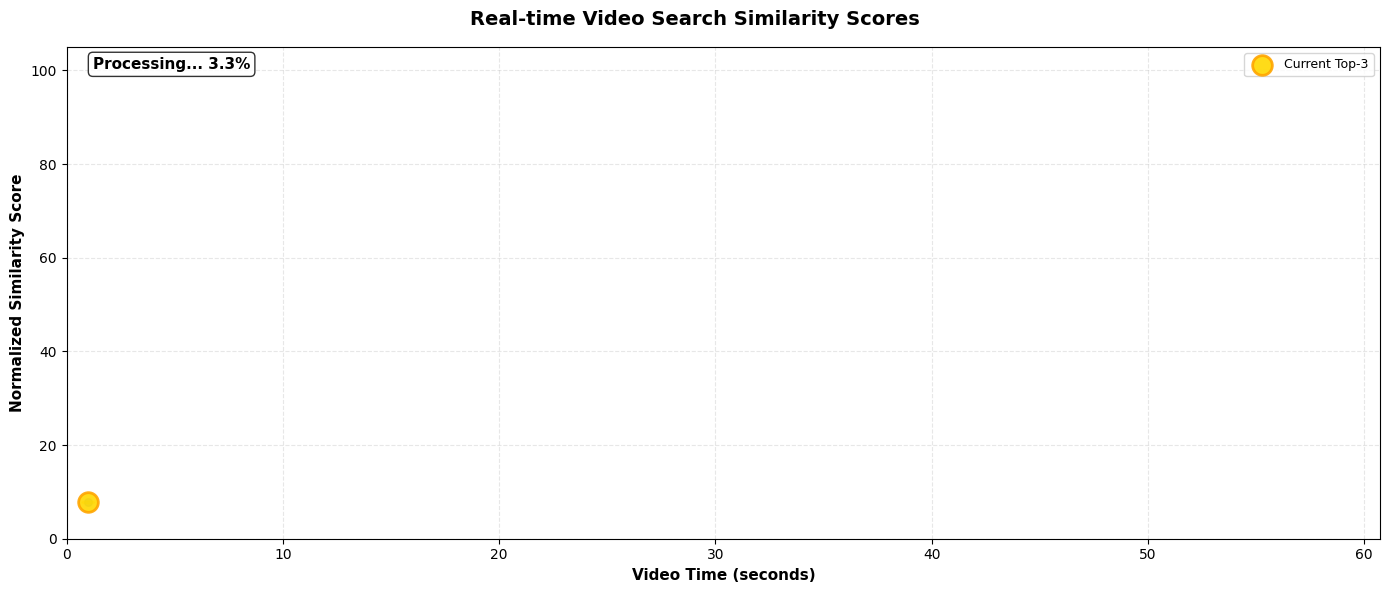

[Window 2/31] 처리 중: 0:00:02 - 0:00:04
  ✅ [Window 2/31] [2.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 2.20, 표준편차: 2.83
  -> 정규화 CLIP 점수: 7.23 (프레임 추출: 0.74초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:00 - 0:00:02 (점수: 7.7417)



<Figure size 640x480 with 0 Axes>

[Window 3/31] 처리 중: 0:00:04 - 0:00:06
  ✅ [Window 3/31] [4.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 2.20, 표준편차: 2.83
  -> 정규화 CLIP 점수: 10.85 (프레임 추출: 0.95초, CLIP 추론: 0.11초)
  ⭐ 새로운 Top 윈도우 발견! (0:00:04 - 0:00:06)



<Figure size 640x480 with 0 Axes>

[Window 4/31] 처리 중: 0:00:06 - 0:00:08
  ✅ [Window 4/31] [6.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 99.90, 표준편차: 80.24
  -> 정규화 CLIP 점수: 9.19 (프레임 추출: 0.94초, CLIP 추론: 0.08초)
  [현재 Top] 0:00:04 - 0:00:06 (점수: 10.8535)



<Figure size 640x480 with 0 Axes>

[Window 5/31] 처리 중: 0:00:08 - 0:00:10
  ✅ [Window 5/31] [8.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 99.84, 표준편차: 67.19
  -> 정규화 CLIP 점수: 10.37 (프레임 추출: 0.89초, CLIP 추론: 0.10초)
  [현재 Top] 0:00:04 - 0:00:06 (점수: 10.8535)



<Figure size 640x480 with 0 Axes>

[Window 6/31] 처리 중: 0:00:10 - 0:00:12
  ✅ [Window 6/31] [10.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 108.48, 표준편차: 55.39
  -> 정규화 CLIP 점수: 9.18 (프레임 추출: 0.88초, CLIP 추론: 0.09초)
  [현재 Top] 0:00:04 - 0:00:06 (점수: 10.8535)



<Figure size 640x480 with 0 Axes>

[Window 7/31] 처리 중: 0:00:12 - 0:00:14
  ✅ [Window 7/31] [12.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 148.16, 표준편차: 80.03
  -> 정규화 CLIP 점수: 11.47 (프레임 추출: 0.83초, CLIP 추론: 0.07초)
  ⭐ 새로운 Top 윈도우 발견! (0:00:12 - 0:00:14)



<Figure size 640x480 with 0 Axes>

[Window 8/31] 처리 중: 0:00:14 - 0:00:16
  ✅ [Window 8/31] [14.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 148.16, 표준편차: 80.03
  -> 정규화 CLIP 점수: 13.79 (프레임 추출: 0.72초, CLIP 추론: 0.07초)
  ⭐ 새로운 Top 윈도우 발견! (0:00:14 - 0:00:16)



<Figure size 640x480 with 0 Axes>

[Window 9/31] 처리 중: 0:00:16 - 0:00:18
  ✅ [Window 9/31] [16.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 86.88, 표준편차: 49.79
  -> 정규화 CLIP 점수: 10.92 (프레임 추출: 0.61초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 10/31] 처리 중: 0:00:18 - 0:00:20
  ✅ [Window 10/31] [18.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 96.61, 표준편차: 76.25
  -> 정규화 CLIP 점수: 2.35 (프레임 추출: 0.70초, CLIP 추론: 0.09초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 11/31] 처리 중: 0:00:20 - 0:00:22
  ✅ [Window 11/31] [20.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 86.66, 표준편차: 64.55
  -> 정규화 CLIP 점수: 0.85 (프레임 추출: 0.56초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 12/31] 처리 중: 0:00:22 - 0:00:24
  ✅ [Window 12/31] [22.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 79.29, 표준편차: 63.51
  -> 정규화 CLIP 점수: 3.91 (프레임 추출: 0.30초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 13/31] 처리 중: 0:00:24 - 0:00:26
  ✅ [Window 13/31] [24.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 0.00, 표준편차: 0.02
  -> 정규화 CLIP 점수: 12.66 (프레임 추출: 0.17초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 14/31] 처리 중: 0:00:26 - 0:00:28
  ✅ [Window 14/31] [26.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 3.62, 표준편차: 1.60
  -> 정규화 CLIP 점수: 12.20 (프레임 추출: 0.19초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 15/31] 처리 중: 0:00:28 - 0:00:30
  ✅ [Window 15/31] [28.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 3.62, 표준편차: 1.60
  -> 정규화 CLIP 점수: 7.66 (프레임 추출: 0.28초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 16/31] 처리 중: 0:00:30 - 0:00:32
  ✅ [Window 16/31] [30.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 95.08, 표준편차: 54.67
  -> 정규화 CLIP 점수: 7.25 (프레임 추출: 0.29초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 17/31] 처리 중: 0:00:32 - 0:00:34
  ✅ [Window 17/31] [32.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 95.08, 표준편차: 54.67
  -> 정규화 CLIP 점수: 7.25 (프레임 추출: 0.30초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 18/31] 처리 중: 0:00:34 - 0:00:36
  ✅ [Window 18/31] [34.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 95.08, 표준편차: 54.67
  -> 정규화 CLIP 점수: 4.28 (프레임 추출: 0.31초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 19/31] 처리 중: 0:00:36 - 0:00:38
  ✅ [Window 19/31] [36.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 107.24, 표준편차: 58.42
  -> 정규화 CLIP 점수: 8.04 (프레임 추출: 0.33초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 20/31] 처리 중: 0:00:38 - 0:00:40
  ✅ [Window 20/31] [38.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 135.42, 표준편차: 77.10
  -> 정규화 CLIP 점수: 13.10 (프레임 추출: 0.33초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 21/31] 처리 중: 0:00:40 - 0:00:42
  ✅ [Window 21/31] [40.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 135.42, 표준편차: 77.10
  -> 정규화 CLIP 점수: 13.11 (프레임 추출: 0.36초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 22/31] 처리 중: 0:00:42 - 0:00:44
  ✅ [Window 22/31] [42.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 125.13, 표준편차: 79.54
  -> 정규화 CLIP 점수: 13.12 (프레임 추출: 0.35초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 23/31] 처리 중: 0:00:44 - 0:00:46
  ✅ [Window 23/31] [44.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 125.13, 표준편차: 79.54
  -> 정규화 CLIP 점수: 13.12 (프레임 추출: 0.34초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 24/31] 처리 중: 0:00:46 - 0:00:48
  ✅ [Window 24/31] [46.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 125.13, 표준편차: 79.54
  -> 정규화 CLIP 점수: 12.94 (프레임 추출: 0.33초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 25/31] 처리 중: 0:00:48 - 0:00:50
  ✅ [Window 25/31] [48.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 119.42, 표준편차: 80.81
  -> 정규화 CLIP 점수: 13.53 (프레임 추출: 0.30초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 26/31] 처리 중: 0:00:50 - 0:00:52
  ✅ [Window 26/31] [50.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 171.71, 표준편차: 73.74
  -> 정규화 CLIP 점수: 9.07 (프레임 추출: 0.35초, CLIP 추론: 0.06초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 27/31] 처리 중: 0:00:52 - 0:00:54
  ✅ [Window 27/31] [52.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 184.36, 표준편차: 34.38
  -> 정규화 CLIP 점수: 8.54 (프레임 추출: 0.42초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 28/31] 처리 중: 0:00:54 - 0:00:56
  ✅ [Window 28/31] [54.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 184.36, 표준편차: 34.38
  -> 정규화 CLIP 점수: 8.54 (프레임 추출: 0.66초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 29/31] 처리 중: 0:00:56 - 0:00:58
  ✅ [Window 29/31] [56.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 184.36, 표준편차: 34.38
  -> 정규화 CLIP 점수: 7.26 (프레임 추출: 0.62초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 30/31] 처리 중: 0:00:58 - 0:01:00
  ✅ [Window 30/31] [58.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 114.80, 표준편차: 36.43
  -> 정규화 CLIP 점수: 5.97 (프레임 추출: 0.58초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>

[Window 31/31] 처리 중: 0:01:00 - 0:01:00
  ✅ [Window 31/31] [60.0s] 첫 프레임 읽기 성공!
  [DEBUG] 첫 프레임 평균 픽셀값: 114.80, 표준편차: 36.43
  -> 정규화 CLIP 점수: 5.97 (프레임 추출: 0.39초, CLIP 추론: 0.07초)
  [현재 Top] 0:00:14 - 0:00:16 (점수: 13.7890)



<Figure size 640x480 with 0 Axes>


[1차 검색 완료] CLIP 점수 기준 상위 3개 후보 선별
1. 0:00:14 - 0:00:16 - 점수: 13.7890
2. 0:00:48 - 0:00:50 - 점수: 13.5312
3. 0:00:42 - 0:00:44 - 점수: 13.1165

[2차 보정 시작] BLIP-2를 사용하여 상위 3개 후보 보정 중...

[후보 1/3] 0:00:14 - 0:00:16
  -> 생성된 캡션: a bathroom with a toilet and a shower
  -> 의미 유사도: 0.6756
  -> 최종 점수: 9.8550
  -> BLIP-2 처리 시간: 0.34초

[후보 2/3] 0:00:48 - 0:00:50
  -> 생성된 캡션: a man is standing in front of a bathroom door
  -> 의미 유사도: 0.5612
  -> 최종 점수: 9.6402
  -> BLIP-2 처리 시간: 0.37초

[후보 3/3] 0:00:42 - 0:00:44
  -> 생성된 캡션: a person in a wheelchair standing in a bathroom
  -> 의미 유사도: 0.6222
  -> 최종 점수: 9.3682
  -> BLIP-2 처리 시간: 0.33초

[최종 순위]
1. 0:00:14 - 0:00:16 - 최종 점수: 9.8550
2. 0:00:48 - 0:00:50 - 최종 점수: 9.6402
3. 0:00:42 - 0:00:44 - 최종 점수: 9.3682



<Figure size 640x480 with 0 Axes>


[📊 시각화 완료] 최종 Top-3 결과가 빨간색 별(★)로 표시되었습니다!

  [시각화] 그래프 저장 완료: viz_CB_2.0, 12, 3, True, 0.7, 0.3_20260123_131128_test.png

[검색 완료] 결과가 CB_2.0, 12, 3, True, 0.7, 0.3_20260123_131128_test.json에 저장되었습니다.
[상세 점수 저장 완료] whole_score_CB_2.0, 12, 3, True, 0.7, 0.3_20260123_131128_test.json
  -> 총 31개 윈도우의 상세 점수 저장됨
[시각화 저장 완료] viz_CB_2.0, 12, 3, True, 0.7, 0.3_20260123_131128_test.png

📊 [전체 실행 시간 분석]
  ⏱️  총 실행 시간: 41.64초

  🔧 초기화 단계:
     - ModelManager 초기화: 383.05초
       ├─ CLIP 로드: 17.93초
       └─ BLIP-2 로드: 365.12초
     - VideoProcessor 초기화: 5.82초
     - 전체 초기화: 0.00초

  🔍 검색 단계:
     - API 호출 (쿼리 분석): 19.86초
     - 프레임 추출: 15.76초
     - CLIP 추론: 2.28초
     - BLIP-2 추론: 1.04초
     - 전체 검색: 21.78초

🧹 임시 이미지 폴더가 성공적으로 정리되었습니다: results/temp_thumbs


In [18]:
# ==========================================
# 5. Main Execution
# ==========================================
def main():
    # 전역 변수 선언 (함수 안에서 전역 변수를 사용/수정하기 위해 필요)
    global model_manager, video_processor

    # 전체 실행 시간 측정 시작
    program_start_time = time.time()

    # --- Configurations ---
    VIDEO_PATH = "/content/YAI_17_Winter_Project/my_video.MP4"# 준비된 비디오 파일 경로
    SAVE_PATH = "results"
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
    else:
        print(f"Save path '{SAVE_PATH}' already exists. Results will be saved here.")
    QUERY = "브이하는 장면"
    # "바닥에 떨어지는 카드를 보고 난감한 표정을 짓는 남자" # 테스트 쿼리

    # Experiments Parameters
    p_list = [2.0, 4.0]      # 윈도우 크기 (초)
    q_list = [12, 24, 48]         # 샘플링 프레임 수
    k_list = [3, 5]          # Top-K 개수
    WEIGHT_CLIP = 0.7
    WEIGHT_SEMANTIC = 0.3
    USE_LOOP = False         # 반복 실행 여부

    # Initialize
    if not os.path.exists(VIDEO_PATH):
        print(f"Error: Video file '{VIDEO_PATH}' not found. Please place a dummy video.")
        return

    # 초기화 시간 측정
    init_start_time = time.time()
    # Initialize (전역 변수로 저장)
    # 이미 초기화되었는지 확인

    # main() 함수 안 (1001줄 앞에 추가)
    print(f"[DEBUG] 'model_manager' in globals(): {'model_manager' in globals()}")
    if 'model_manager' in globals():
        print(f"[DEBUG] model_manager is None: {model_manager is None}")
        print(f"[DEBUG] model_manager 값: {model_manager}")

    if 'model_manager' not in globals() or model_manager is None:
        print("🔄 ModelManager 초기화 중...")
        init_start_time = time.time()
        model_manager = ModelManager(use_blip=USE_BLIP)
        print(f"✅ ModelManager 초기화 완료 ({time.time() - init_start_time:.2f}초)")
    else:
        print("♻️ 기존 ModelManager 재사용 (메모리 절약!)")
    if 'video_processor' not in globals() or video_processor is None:
        print("🔄 VideoProcessor 초기화 중...")
        video_processor = VideoProcessor(VIDEO_PATH)
        print(f"✅ VideoProcessor 초기화 완료 ({time.time() - init_start_time:.2f}초)")
    else:
        print("♻️ 기존 VideoProcessor 재사용 (메모리 절약!)")
    engine = AdaptiveSearchEngine(model_manager, video_processor)
    total_init_time = time.time() - init_start_time

    print(f"\n[쿼리 분석] '{QUERY}'")
    sub_queries, split_reason = engine.split_query(QUERY)
    print(f"[분할된 쿼리] {sub_queries}\n")

    # Experiment Loop
    # 반복 실행 할 때
    if USE_LOOP:
        for p in p_list:
            for q in q_list:
                for k in k_list:
                    print(f"\n--- Running Experiment: p={p}, q={q}, k={k} ---")

                    # Perform Search (실시간 시각화 활성화)
                    results, all_windows_data, visualizer = engine.search(QUERY, sub_queries, p, q, k, WEIGHT_CLIP, WEIGHT_SEMANTIC, enable_visualization=True, save_path=SAVE_PATH)

                    # 전체 실행 시간 계산
                    total_elapsed_time = time.time() - program_start_time

                    # Construct Filename
                    model_name = "CB" if USE_BLIP else "Clip"
                    timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                    # 유의미한 결과 나왔으면 _test.json 대신 .json 확장자 사용
                    filename = f"{model_name}_{p}, {q}, {k}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test.json"
                    filename_base = f"{model_name}_{p}, {q}, {k}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test"

                    # 시각화 저장
                    if visualizer:
                        try:
                            viz_filename = visualizer.save_and_close(filename_base)
                        except Exception as e:
                            print(f"  [시각화] 저장 실패: {e}")
                            viz_filename = None
                    else:
                        viz_filename = None

                    # 타이밍 정보 수집
                    timing_data = collect_timing_data(total_elapsed_time, total_init_time,
                                                    model_manager, video_processor, engine)

                    # Output Data Structure
                    output_data = {
                        "meta": {
                            "video_path": VIDEO_PATH,
                            "query": QUERY,
                            "sub_queries": sub_queries,
                            "split_reason": split_reason,
                            "parameters": {"p": p, "q": q, "k": k, "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                            "model": model_name,
                            "timestamp": timestamp_str
                        },
                        "time_used": timing_data,
                        "results": results
                    }

                    # Save to JSON
                    with open(os.path.join(SAVE_PATH, filename), "w", encoding='utf-8') as f:
                        json.dump(output_data, f, indent=4, ensure_ascii=False)

                    # 모든 윈도우의 상세 점수 저장
                    whole_score_filename = f"whole_score_{filename}"
                    whole_score_data = {
                        "meta": {
                            "video_path": VIDEO_PATH,
                            "query": QUERY,
                            "sub_queries": sub_queries,
                            "parameters": {"p": p, "q": q, "k": k, "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                            "total_windows": len(all_windows_data),
                            "timestamp": timestamp_str
                        },
                        "all_windows": all_windows_data
                    }
                    with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding='utf-8') as f:
                        json.dump(whole_score_data, f, indent=4, ensure_ascii=False)

                    print(f"\n[저장 완료] {filename}")
                    print(f"[상세 점수 저장 완료] {whole_score_filename}")
                    print(f"  -> 총 {len(all_windows_data)}개 윈도우의 상세 점수 저장됨")
                    if viz_filename:
                        print(f"[시각화 저장 완료] {viz_filename}")
                    print(f"[총 실행 시간] {total_elapsed_time:.2f}초\n")
                    cleanup_temp_images(SAVE_PATH)

    # 반복 실행 아닐 때
    else:
        results, all_windows_data, visualizer = engine.search(QUERY, sub_queries, p_list[0], q_list[0], k_list[0], WEIGHT_CLIP, WEIGHT_SEMANTIC, enable_visualization=True, save_path=SAVE_PATH)

        # 전체 실행 시간 계산
        total_elapsed_time = time.time() - program_start_time

        model_name = "CB" if USE_BLIP else "Clip"
        timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{model_name}_{p_list[0]}, {q_list[0]}, {k_list[0]}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test.json"
        filename_base = f"{model_name}_{p_list[0]}, {q_list[0]}, {k_list[0]}, {USE_BLIP}, {WEIGHT_CLIP if USE_BLIP else ''}, {WEIGHT_SEMANTIC if USE_BLIP else ''}_{timestamp_str}_test"

        # 시각화 저장
        if visualizer:
            try:
                viz_filename = visualizer.save_and_close(filename_base)
            except Exception as e:
                print(f"  [시각화] 저장 실패: {e}")
                viz_filename = None
        else:
            viz_filename = None

        # 타이밍 정보 수집
        timing_data = collect_timing_data(total_elapsed_time, total_init_time,
                                        model_manager, video_processor, engine)

        # Output Data Structure
        output_data = {
            "meta": {
                "video_path": VIDEO_PATH,
                "query": QUERY,
                "sub_queries": sub_queries,
                "split_reason": split_reason,
                "parameters": {"p": p_list[0], "q": q_list[0], "k": k_list[0], "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                "model": model_name,
                "timestamp": timestamp_str
            },
            "time_used": timing_data,
            "results": results
        }

        # Save to JSON
        with open(os.path.join(SAVE_PATH, filename), "w", encoding='utf-8') as f:
            json.dump(output_data, f, indent=4, ensure_ascii=False)

        # 모든 윈도우의 상세 점수 저장
        whole_score_filename = f"whole_score_{filename}"
        whole_score_data = {
            "meta": {
                "video_path": VIDEO_PATH,
                "query": QUERY,
                "sub_queries": sub_queries,
                "parameters": {"p": p_list[0], "q": q_list[0], "k": k_list[0], "USE_BLIP": USE_BLIP, "WEIGHT_CLIP": WEIGHT_CLIP, "WEIGHT_SEMANTIC": WEIGHT_SEMANTIC},
                "total_windows": len(all_windows_data),
                "timestamp": timesㄴtamp_str
            },
            "all_windows": all_windows_data
        }
        with open(os.path.join(SAVE_PATH, whole_score_filename), "w", encoding='utf-8') as f:
            json.dump(whole_score_data, f, indent=4, ensure_ascii=False)

        print(f"\n{'='*60}")
        print(f"[검색 완료] 결과가 {filename}에 저장되었습니다.")
        print(f"[상세 점수 저장 완료] {whole_score_filename}")
        print(f"  -> 총 {len(all_windows_data)}개 윈도우의 상세 점수 저장됨")
        if viz_filename:
            print(f"[시각화 저장 완료] {viz_filename}")
        print(f"{'='*60}")
        print(f"\n📊 [전체 실행 시간 분석]")
        print(f"{'='*60}")
        print(f"  ⏱️  총 실행 시간: {total_elapsed_time:.2f}초")
        print(f"\n  🔧 초기화 단계:")
        print(f"     - ModelManager 초기화: {model_manager.init_time:.2f}초")
        print(f"       ├─ CLIP 로드: {model_manager.clip_load_time:.2f}초")
        print(f"       └─ BLIP-2 로드: {model_manager.blip_load_time:.2f}초")
        print(f"     - VideoProcessor 초기화: {video_processor.init_time:.2f}초")
        print(f"     - 전체 초기화: {total_init_time:.2f}초")
        print(f"\n  🔍 검색 단계:")
        print(f"     - API 호출 (쿼리 분석): {engine.timing_info['api_call_time']:.2f}초")
        print(f"     - 프레임 추출: {engine.timing_info['frame_extraction_time']:.2f}초")
        print(f"     - CLIP 추론: {engine.timing_info['clip_inference_time']:.2f}초")
        if USE_BLIP:
            print(f"     - BLIP-2 추론: {engine.timing_info['blip_inference_time']:.2f}초")
        print(f"     - 전체 검색: {engine.timing_info['total_search_time']:.2f}초")
        print(f"{'='*60}\n")
        cleanup_temp_images(SAVE_PATH)

if __name__ == "__main__":
    main()

## 8. 실행 예제

위의 main() 함수를 실행하거나, 아래처럼 직접 실행할 수 있습니다:

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_top_k_candidates(top_k_candidates):
    k = len(top_k_candidates)
    plt.figure(figsize=(5 * k, 5))

    for i, item in enumerate(top_k_candidates):
        img = Image.open(item["temp_img_path"])

        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Rank {i+1}\n"
            f"{item['timestamp']}\n"
            f"score={item['clip_score_norm']:.4f}"
        )

    plt.show()

In [21]:
visualize_top_k_candidates(top_k_candidates)

NameError: name 'top_k_candidates' is not defined